# Educational levels in Denmark

**Table of contents**<a id='toc0_'></a>    
1. [Cleaning dataset for population ](#toc1_)       
2. [Cleaning dataset for educational level  ](#toc2_)      
3. [Merging the datasets](#toc3_) 
4. [Creating geodataframes for plotting](#toc4_) 
5. [Analysis](#toc5_)    
6. [Conclusion](#toc6_) 

<!-- vscode-jupyter-toc-config
	numbering=true
	anchor=true
	flat=false
	minLevel=2
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

Education plays a crucial role in human development and is widely considered a key component of economic growth. It is important to keep an eye out for the progress of education levels across different regions to identify areas that may require policy intervention and initiatives. In this analysis, we focus on differences in the educational levels. Specifically, we investigate the share of population with various education levels and examine how it evolves over time and varies across municipalities and regions.

By understanding and analyzing the patterns and trends in educational levels, policymakers can effectively allocate resources to prioritize educational initiatives in areas where they are most needed.

Through our analysis, we only examine individuals in the age group 25 - 39. 

There are several reasons for this selection:
- By the age of 25 people have typically completed their education and reached their highest level of education. Examining a younger population would likely result in distorted numbers and misleading conclusions. Fewer individuals would have completed a higher education thereby increasing the ratio of population with a low education level. By focusing on the educational level within this age group policymakers can identify educational imbalances. 
- The 25-39 age group is a significant contributor to the labor force and will remain so for a long period. Thus, the educational composition within this age group plays a vital role in meeting the demands of the job market. Insufficient educational levels within this age group can lead to a shortage of skilled individuals. Also, it can lead to other imbalances such as an overabundance of highly educated individuals and a disproportionate representation of workers in vocational positions.

Therefore, by examining educational levels within the 25-39 age group, policymakers can identify gaps in educational attainment, design targeted interventions, and allocate resources effectively. 

We start by importing and installing the necessary packages and libraries. 

In [1]:
# Installing packages 
%pip install git+https://github.com/elben10/pydst -q
%pip install pandas-datareader -q
%pip install geopandas -q
%pip install mapclassify -q
%pip install folium -q
%pip install branca -q
%pip install fiona -q

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [10]:
# Importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
import seaborn as sns
import pandas_datareader
import pydst 
import seaborn as sns 
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import ipywidgets as widgets

# Autoreload modules when code is run
%load_ext autoreload
%autoreload 2

# import dataproject
import dataproject as dataproject
dp = dataproject.dataprojectclass()


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## 1. <a id='toc1_'></a>[Cleaning dataset for population ](#toc0_)

In this section, we clean the first dataset, which contains danish population data.


**Procedure:**
1. Extracting data from DST for the years 2010 and 2022.

2. Generating separate datasets for each year using a loop.

3. Concatenating the separate datasets to create a combined dataset for both years.

4. Keeping only the observations within the age group of 25 to 39 years.

5. Summing the population data over all age groups within each municipality using the groupby function.




We want to simplify our results by aggregating data from the 99 municipalities into 5 regions. 

6. We merge the dataframe with a file uploaded to the data project folder that associates each municipality with its corresponding region.

NB: It takes around 1 minut to run this code
 

In [3]:
# Creating lists for the two years that we want to examine
year = [2010, 2022]
year_string = [str(y) for y in year]

# Creating empty population dataframe dictionary
pop_df = {}
 
# Extracting population data from DST and cleaning data
for (year, year_string) in zip(year, year_string):

    variables = {'KOMK':['*'], 'ALDER':['*'], 'TID':[year_string], 'KØN':['*'],'BYST':["*"]}
    df = dp.get_data("BY2", variables)
    df.rename(columns={'KOMK': 'Municipalities', 'ALDER': 'Age', 'TID': 'Date','INDHOLD': 'Value'}, inplace=True)
    
    # Converting string to float to exclude population that are not in the desired agegroup (25 - 39 years) 
    df['Age'] = dp.string_to_float(df["Age"], " years")
    df.loc[df['Age'].between(25,39), 'Age group'] = '25-39'
    
    # Dropping observations outside time frame (2010 and 2022) and outside age group (25 - 39 years)
    dp.drop_obs(df, "Date", year, equality = "not_equal")
    dp.drop_obs(df, "Age group", '25-39' , equality = "not_equal")
    
    # Summing over the variables for municipalities and dropping duplicates, so that there is one observation per municipality. 
    # Dropping unnecessary columns
    df['total_pop'] = df.groupby(['Municipalities'])['Value'].transform('sum')
    dp.drop_variables(df, ['Age', 'BYST', "Value", "KØN", "Age group"])
    df = df.drop_duplicates(subset=("Municipalities"))
    
    # Creating a dataframe for each year
    pop_df[year] = df

# Directing to placement of each dataset in dictionary
pop_df2010 = pop_df[2010]
pop_df2022 = pop_df[2022]

# Concatenate datasets
pop_df_concatenate = pd.concat([pop_df2010,pop_df2022])

# Merging data set with excel file containing region names for each municipality
reg_mun = pd.read_excel("kommuneliste.xlsx")

# Changing name of København to Copenhagen so that the data sets can merge properly
reg_mun = reg_mun.replace("København", "Copenhagen")
reg_mun.rename(columns={'KOMK': 'Municipalities'}, inplace=True)

# Merging the dataset to the population dataset using municipalities
pop_df_concatenate = pd.merge(reg_mun, pop_df_concatenate, how = 'inner', on = ['Municipalities'])
pop_df_concatenate['total_pop_region'] = pop_df_concatenate.groupby(["Date","REGION"])['total_pop'].transform('sum')

  ## 2. <a id='toc2_'></a>[Cleaning dataset for educational level  ](#toc0_)

In this section, we perform data cleaning for the second dataset, which contains danish education data. 

**Procedure:**

*The process follows a similar procedure as the first dataset cleaning.*

1. To simplify the analysis, we group five different types of higher education together under the label *higher education*. 

2. Keeping only obervations where individuals have completed primary education, vocational education and training (VET) or higher education as their highest level of education.

NB: It takes around 1 minut to run this code

In [4]:
# Creating lists for the two years that we want to examine
year = [2010, 2022]
year_string = [str(y) for y in year]

# Creating empty education dataframe dictionary
edu_df = {}
 
# Extracting and cleaning education data from DST
for (year, year_string) in zip(year, year_string):

    variables = {'BOPOMR':['*'], 'ALDER':['*'], 'HFUDD':['*'], 'TID':[year_string]}
    df_hf = dp.get_data("HFUDD11", variables)
    df_hf.rename(columns={'BOPOMR': 'Municipalities', 'ALDER': 'Age group', 'TID': 'Date', 'INDHOLD': 'Value'}, inplace=True)
    dp.drop_obs(df_hf, "Date", year , equality = "not_equal")

    # Dropping obs by using a dummy variable for whether the observations belong to the age group (25 - 39 years)
    age_list = ["25-29", "30-34", "35-39"]
    for x in age_list:
        df_hf.loc[df_hf['Age group'] == x + " years", 'dummy'] = 1
    dp.drop_obs(df_hf, "dummy", 1 , equality = "not_equal")

    # Defining variabel for total population in education in each muncipality
    df_hf['total_in_education'] = df_hf.groupby(['Municipalities', "HFUDD"])['Value'].transform('sum')
    
    # Dropping irrelevant columns
    dp.drop_variables(df_hf, ["Age group", "dummy",  "HERKOMST", "KØN", "Value"])

    # Keeping only relevant education types and grouping higher level education
    education_list = ["H10 Primary education", "H30 Vocational Education and Training (VET)", "H40 Short cycle higher education","H50 Vocational bachelors educations", "H60 Bachelors programs","H70 Masters programs","H80 PhD programs"]
    new_education_list = ["Primary education", "VET", "Higher education", "Higher education", "Higher education", "Higher education", "Higher education"]
    for i in range(7):
        df_hf.loc[df_hf['HFUDD'] == education_list[i], 'EDUCATION'] = new_education_list[i]
    df_hf = df_hf.dropna(subset=["EDUCATION"])

    df_hf = df_hf.drop_duplicates(subset=("Municipalities", "HFUDD"))
    df_hf['total_in_education'] = df_hf.groupby(["Municipalities", 'EDUCATION'])['total_in_education'].transform('sum')
    
    # Dropping duplicates of municipalities and education
    # Now having (99 municipalities + 1 total in Denmark + 5 regions) * 3 education levels = 315 obs for 2010. For 2022 number of obs is 314 due to Christiansø Municipality being very small.

    df_hf = df_hf.drop_duplicates(subset=("Municipalities", "EDUCATION"))
    
    # Drop variable
    dp.drop_variables(df_hf, ["HFUDD"])


# Creating a new dataframe
    edu_df[year] = df_hf

# Dataframe for education in each of the two years
edu_df2010 = edu_df[2010]
edu_df2022 = edu_df[2022]

# Concatenate datasets
edu_df_concatenate = pd.concat([edu_df2010, edu_df2022])

  ## 3. <a id='toc3_'></a>[Merging the datasets  ](#toc0_)

**Procedure:**
1. Merging the population dataset and education dataset using the shared columns "Municipalities" and "Time".

*Performing an inner join to ensure data availability for all municipalities, even exceptionally small ones like Christiansø. This step is not crucial since both datasets contain data for all municipalities across both years.*

2. Creating a dataset for regions by grouping the data by regions and dropping all duplicates.

3. Calculating the ratio of individuals with a particular type of education as their highest level of completed education within each region. This ratio provides insights into the educational composition of different regions.

In [5]:
# Merging the population and education dataset using municipalities and time
df_municipalities = pd.merge(pop_df_concatenate, edu_df_concatenate, how = 'inner', on = ['Municipalities', "Date"]);

df_municipalities["ratio"]=df_municipalities["total_in_education"]/df_municipalities["total_pop"]*100


df_reg = df_municipalities.copy()
# Summing over region and educational level
df_reg['total_in_education_region'] = df_reg.groupby(["Date", "REGION", 'EDUCATION'])['total_in_education'].transform('sum')

# Dropping duplicates and columns

df_reg = df_reg.drop_duplicates(subset=("Date","REGION", "EDUCATION"))
dp.drop_variables(df_reg, ['Municipalities','total_pop','total_in_education'])

# Calculating ratio in each region
df_reg["ratio"]=df_reg["total_in_education_region"]/df_reg["total_pop_region"]*100
df_reg["ratio"]=df_reg["ratio"].round(2)


# Printing the final regional dataset
df_reg.head(10)


,REGION,Date,total_pop_region,EDUCATION,ratio,total_in_education_region
0,Region Hovedstaden,2010,372412,Primary education,15.47,57615
1,Region Hovedstaden,2010,372412,VET,22.95,85458
2,Region Hovedstaden,2010,372412,Higher education,46.56,173403
3,Region Hovedstaden,2022,419307,Primary education,10.92,45791
4,Region Hovedstaden,2022,419307,VET,15.42,64660
5,Region Hovedstaden,2022,419307,Higher education,65.02,272618
179,Region Sjælland,2010,133024,Primary education,21.01,27943
180,Region Sjælland,2010,133024,VET,40.99,54532
181,Region Sjælland,2010,133024,Higher education,27.55,36648
182,Region Sjælland,2022,131089,Primary education,20.32,26643


  ## 4. <a id='toc4_'></a>[Creating geodataframes for plotting ](#toc0_)

In [12]:
# Creating a dictionary of geodataframes for plotting
gpd1 = gpd.read_file('kommuner.geojson')
gpd1 = gpd1.rename(columns={'KOMNAVN':'Municipalities'})
gpd1 = gpd1.replace("København", "Copenhagen")

education_list = ['Primary education', "VET", "Higher education"]
date_list = [2010, 2022] 

map_dict = {}  # Dictionary to store map_df values

for education in education_list:
    for date in date_list:
        clean_df = df_municipalities.loc[(df_municipalities['EDUCATION'] == education) & (df_municipalities['Date'] == date)] #Keep only relevant obs
        merge_df = pd.merge(clean_df, gpd1, how = 'inner', on = ['Municipalities']); #Merge on GEOSJON file
        map_df = gpd.GeoDataFrame(merge_df, geometry='geometry') # Transform to Geodataframe
        key = f"{education}_{date}"  # Generate a unique key based on education and date
        map_dict[key] = map_df
        


  ## 5. <a id='toc5_'></a>[Analysis ](#toc0_)

The map below illustrates the ratio of individuals with **primary education** as their highest educational level across Danish municipalities in 2022. One noticeable trend is that the ratio of individuals with primary education decreases as we move closer to major cities. This suggests that areas in proximity to urban centers tend to have a higher proportion of individuals with higher educational levels.

One municipality that stands out is Lolland in southern Denmark, which has the largest share of the population with primary education as their highest educational level. The share for Lolland was in 2022 32.6 pct.

The bar chart illustrates the ratio of individuals with primary education as their highest educational level in the five regions for the years 2010 and 2022. The x-axis represents the 5 regions in Denmark, while the y-axis indicates the percentage of people with primary education as their highest education level. The bars are color-coded to distinguish between the years, with blue representing 2010 and orange representing 2022.
The ratio of individuals with primary education as their highest educational level has declined across all regions from 2010 to 2022. This decline indicates a shift towards higher levels of education in the population over the years.

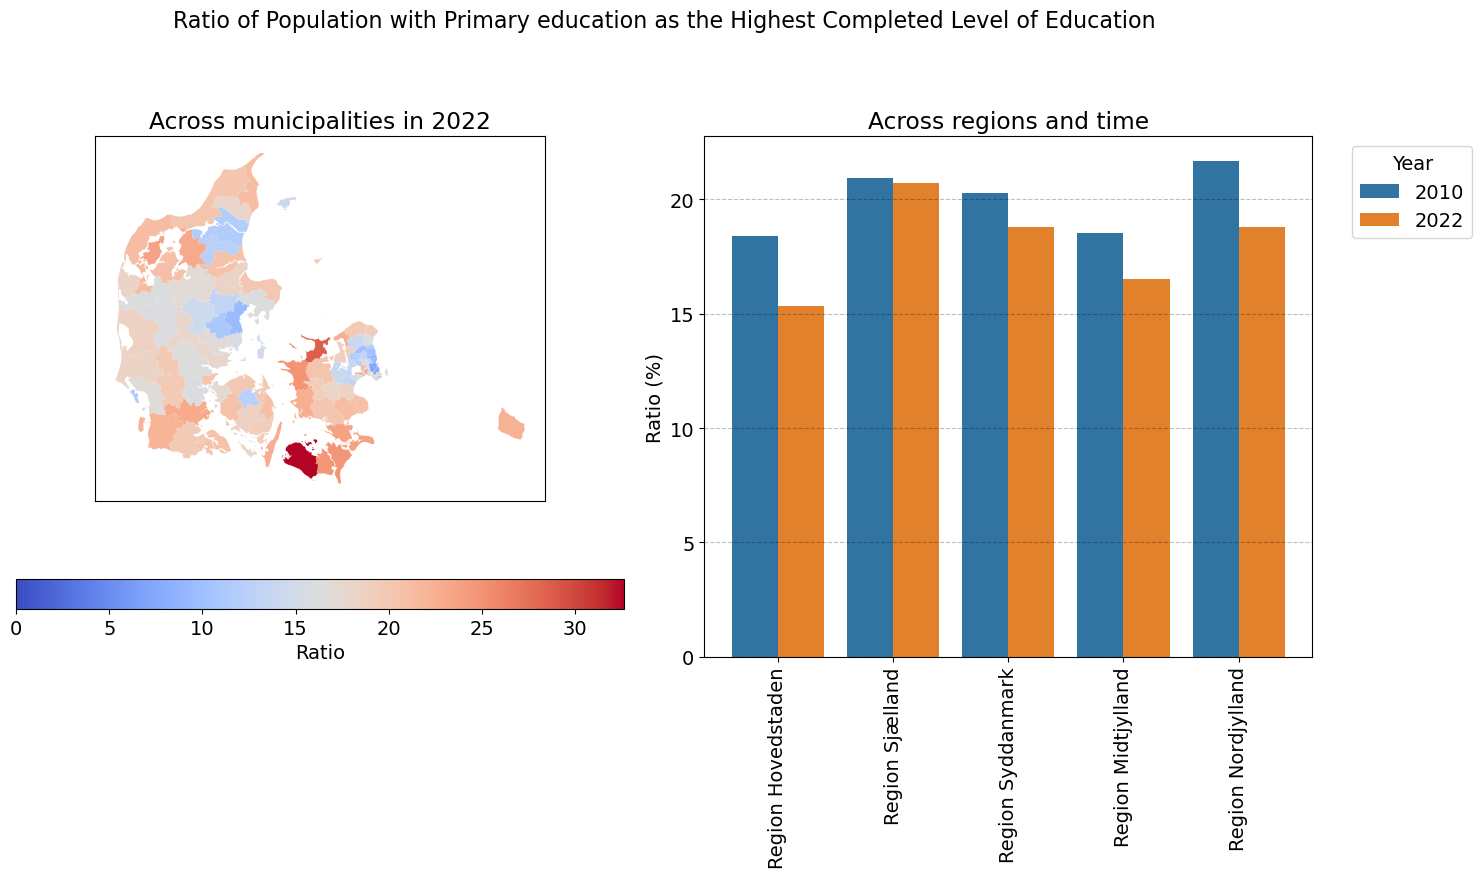

The ratio for Lolland was 32.6 pct. in 2022.


In [7]:
dp.subplot(map_dict, df_municipalities, 'Primary education_2022', 'Primary education')

print(dp.ratio(map_dict['Primary education_2022'], "Lolland"))


**VET**, which stands for Vocational Education and Training, includes a diverse range of occupations that emphasize practical skills and specialized training. Examples of VET occupations include carpenters, hairdressers, mechanics and many more. 

The ratio of individuals with a VET education decreases as we move towards larger cities and the ratio in Copenhagen is only 9.2. As with the ratio of low educated individuals, the ratio of individuals with a VET education has declined since 2010 in all regions and is highest in the region of northern Jutland.


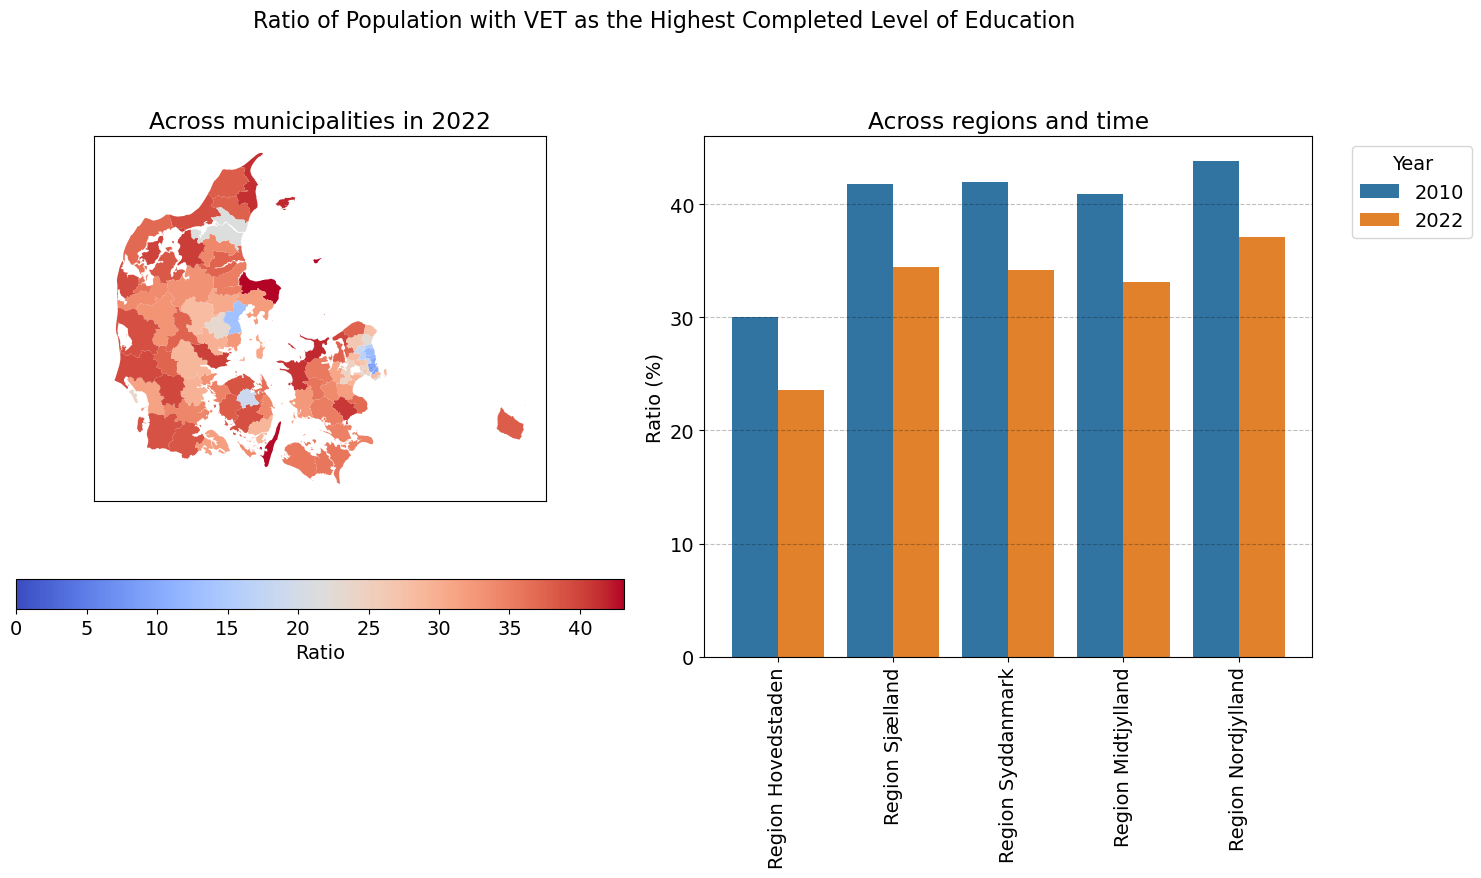

The ratio for Copenhagen was 9.2 pct. in 2022.


In [8]:
dp.subplot(map_dict, df_municipalities, 'VET_2022', 'VET')
print(dp.ratio(map_dict['VET_2022'], "Copenhagen"))


Unlike primary education and VET, the ratio of individuals with a **higher education** is notably higher in cities, while relatively lower outside of cities. 
In the context of ratios, it is important to note that as the share of individuals with higher education increases in a particular area, the shares of individuals with other education levels are comparatively lower. For example, in Copenhagen, the capital city of Denmark, the share of individuals with higher education is 73.7 pct., indicating a relatively high educational level compared to other regions. This implies that the shares of individuals with lower education levels or VET education are relatively lower in Copenhagen.


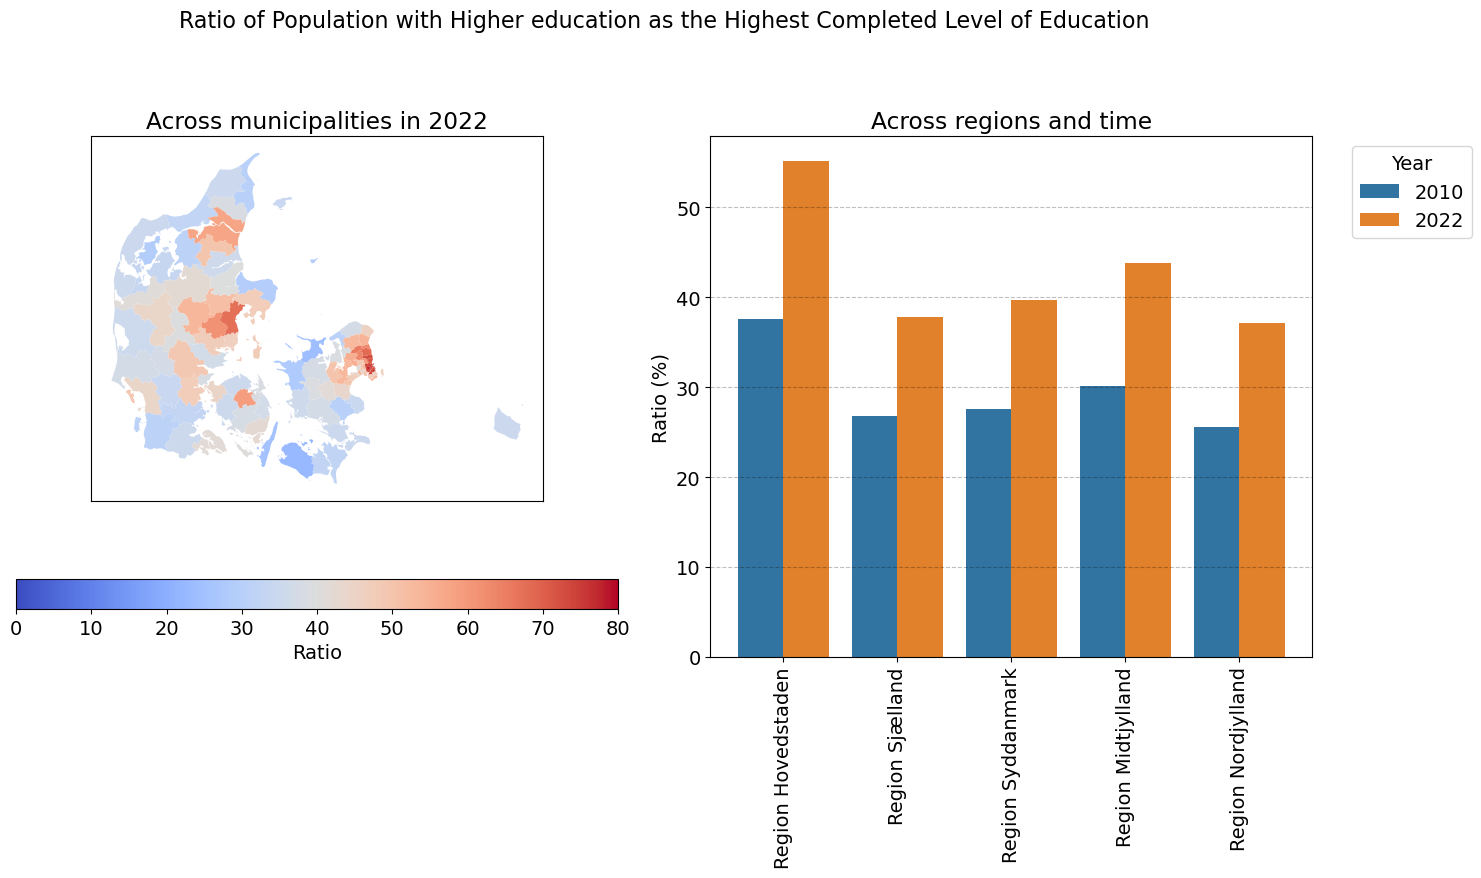

The ratio for Copenhagen was 73.7 pct. in 2022.


In [9]:
dp.subplot(map_dict, df_municipalities, 'Higher education_2022', 'Higher education', max_value=80)
print(dp.ratio(map_dict['Higher education_2022'], "Copenhagen"))

  ## 6. <a id='toc6_'></a>[Conclusion ](#toc0_)

In conclusion, the analysis reveals significant changes in education levels in Denmark over the years. Across all regions, there has been a decrease in the population share with low education levels, and an increase in the proportion of individuals with higher levels of education. A concerning trend is the decline in vocational education and training (VET) over time. This is an area of concern that policymakers should closely observe. The decreasing popularity of VET programs may affect the availability of skilled workers in specific industries and the overall labor market in the future. 

Furthermore, the analysis shows a pattern of higher education levels in larger cities, particularly in Copenhagen. This observation aligns with the fact that the cities are student cities, attracting individuals who choose to stay after completing their education. 
However, the lower presence of higher education levels in non-urban areas may suggest that individuals living outside larger cities face difficulties accessing higher education. Limited availability of educational institutions in these areas may hinder their ability to pursue higher education without relocating. This disparity in educational access between urban and rural areas highlights the need for policymakers to address the unequal opportunities for education based on geographic location.